In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#-------------------------------------------------------------------

Загружаем данные

In [4]:
#from google.colab import drive
#drive.mount("/content/gdrive")
#test_dataset = np.load('/content/gdrive/My Drive/Colab Notebooks/hieroglyphs/test.npy', allow_pickle = True)
#train_dataset = np.load('/content/gdrive/My Drive/Colab Notebooks/hieroglyphs/train.npy', allow_pickle = True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Разделяем на тестовую и валидационную

In [5]:
train_percent = 0.8

#X_train, X_val, y_train, y_val = train_test_split(train_dataset[:,0], train_dataset[:,1], test_size=(1-train_percent), random_state=42)

train_size = int(len(train_dataset) * train_percent)
X_train, y_train = train_dataset[:train_size,0], train_dataset[:train_size,1]
X_val, y_val  = train_dataset[train_size:,0], train_dataset[train_size:,1]

print("Dataset train size:", len(train_dataset))
print("Dataset test size:", len(test_dataset))
print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Image size:", X_train[0].shape)

Dataset train size: 166708
Dataset test size: 41428
Train size: 133366
Validation size: 33342
Image size: (56, 67)


Перенумеруем

In [6]:
dict_new_labels = dict()
for i in (set(train_dataset[:,1])):
    dict_new_labels[i] = dict_new_labels.get(i, len(dict_new_labels))

dict_old_labels = {y: x for x, y in dict_new_labels.items()}

y_train = np.array([dict_new_labels[i] for i in y_train])
y_val = np.array([dict_new_labels[i] for i in y_val])

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

print("y_train:", y_train)
print("max_y:", max(y_train))

y_train: tensor([201, 262, 333,  ...,   5, 141, 126])
max_y: tensor(499)


Обработка данных

In [7]:
img_size = 56
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((img_size, img_size)),
     transforms.Normalize((0.5), (0.5))
    ])

class HieroglyphsDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __getitem__(self, idx):
        return {'img': self.transform(self.X[idx]), 'label': self.y[idx]}
    
    def __len__(self):
        return len(self.X)
        
train = HieroglyphsDataset(X_train, y_train)
validation = HieroglyphsDataset(X_val, y_val)
test =  HieroglyphsDataset(test_dataset, [0] * len(test_dataset))

#-------------------------------------------------------------------
Посмотрим датасет

In [8]:
def create_dict(X):
    dictionary = {}
    for i in range(len(X)):
        if X[i]['label'].item() in dictionary:
            dictionary[X[i]['label'].item()].append(X[i]['img'])
        else:
            dictionary[X[i]['label'].item()] = list((X[i]['img']))
    return dictionary
#dictionary = create_dict(train)

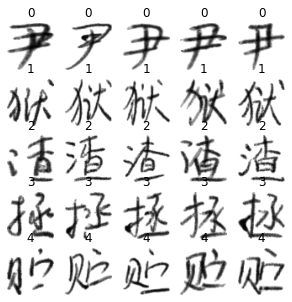

In [9]:
def show_dictionary(dictionary, plot_height = 5, plot_width=10):
    fig, axs = plt.subplots(plot_height, plot_width, figsize=(plot_width, plot_height))
    for i, key in enumerate(sorted(dictionary.keys())):
        if i >= plot_height:
            break
        for j, value in  enumerate(dictionary[key]):
            if j >= plot_width:
                break
            axs[i][j].title.set_text(key)
            axs[i][j].imshow(value.reshape((img_size, img_size)), cmap="gray")
            axs[i][j].axis('off')
#show_dictionary(dictionary, 5, 5)

#-------------------------------------------------------------------
Точность и обучение

In [10]:
def accuracy(model, data):
    correct = 0
    total = 0
    for d in data:
        X, y = d.values()
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        predicted = torch.argmax(outputs.data, dim=1)
        total += predicted.shape[0]
        correct += (predicted == y).sum()
    return (correct / total).item()

In [11]:
def Train(model, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs): 
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data.values()
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 0:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
        if True:
            print("Accuracy train:", accuracy(model, train_loader))
            print("Accuracy validation:", accuracy(model, val_loader))
    return model

#-------------------------------------------------------------------
Обучаем

1

In [12]:
class CoolNet(nn.Module):
    def __init__(self, num_classes=500):
        super(CoolNet, self).__init__()
        #56 * 56 * 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(16)
        #56 * 56 * 16
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        #28 * 28 * 16
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.batch_norm2 = nn.BatchNorm2d(32)
        #28 * 28 * 32
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        #14 * 14 * 32
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu6 = nn.ReLU()
        self.batch_norm3 = nn.BatchNorm2d(64)
        #14 * 14 * 64
        
        self.fc1 = nn.Linear(in_features=14 * 14 * 64, out_features=1000)
        self.tanh = nn.Tanh()

        self.fc2 = nn.Linear(in_features=1000, out_features=num_classes)
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.batch_norm1(output)

        output = self.pool1(output)

        output = self.conv3(output)
        output = self.relu3(output)
        output = self.conv4(output)
        output = self.relu4(output)
        output = self.batch_norm2(output)
        
        output = self.pool2(output)

        output = self.conv5(output)
        output = self.relu5(output)
        output = self.conv6(output)
        output = self.relu6(output)
        output = self.batch_norm3(output)

        output = output.view(-1, 14 * 14 * 64)

        output = self.fc1(output)
        output = self.tanh(output)

        output = self.fc2(output)

        return output

#batch_size = 500
#train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
#val_loader = torch.utils.data.DataLoader(dataset=validation, batch_size=batch_size, shuffle=True)
#net = CoolNet().to(device)
#print(net)
#net = Train(net, 10)
#0.96596

CoolNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu6): ReLU()
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1

2

In [ ]:
class CoolNet(nn.Module):
    def __init__(self, num_classes=500):
        super(CoolNet, self).__init__()
        #64 * 64 * 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(16)
        #64 * 64 * 16
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        #32 * 32 * 16
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.batch_norm2 = nn.BatchNorm2d(32)
        #32 * 32 * 32
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        #16 * 16 * 32
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu6 = nn.ReLU()
        self.batch_norm3 = nn.BatchNorm2d(64)
        #16 * 16 * 64
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        #8 * 8 * 64
        self.conv7 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu7 = nn.ReLU()
        self.conv8 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu8 = nn.ReLU()
        self.batch_norm4 = nn.BatchNorm2d(128)
        #8 * 8 * 128
        
        self.fc1 = nn.Linear(in_features=8 * 8 * 128, out_features=1000)
        self.tanh = nn.Tanh()

        self.fc2 = nn.Linear(in_features=1000, out_features=num_classes)
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.batch_norm1(output)

        output = self.pool1(output)

        output = self.conv3(output)
        output = self.relu3(output)
        output = self.conv4(output)
        output = self.relu4(output)
        output = self.batch_norm2(output)
        
        output = self.pool2(output)

        output = self.conv5(output)
        output = self.relu5(output)
        output = self.conv6(output)
        output = self.relu6(output)
        output = self.batch_norm3(output)

        output = self.pool3(output)

        output = self.conv7(output)
        output = self.relu7(output)
        output = self.conv8(output)
        output = self.relu8(output)
        output = self.batch_norm4(output)

        output = output.view(-1, 8 * 8 * 128)

        output = self.fc1(output)
        output = self.tanh(output)

        output = self.fc2(output)

        return output

#batch_size = 500
#train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
#net = CoolNet().to(device)
#print(net)
#net = Train(net, 5)
#0.97163

3

In [ ]:
class CoolNet(nn.Module):
    def __init__(self, num_classes=500):
        super(CoolNet, self).__init__()
        #64 * 64 * 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(64)
        #64 * 64 * 64
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        #32 * 32 * 64
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu6 = nn.ReLU()
        self.batch_norm2 = nn.BatchNorm2d(128)
        #32 * 32 * 128
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        #16 * 16 * 128
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu7 = nn.ReLU()
        self.conv8 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu8 = nn.ReLU()
        self.conv9 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu9 = nn.ReLU()
        self.batch_norm3 = nn.BatchNorm2d(256)
        #16 * 16 * 256
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        #8 * 8 * 256
        self.conv10 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu10 = nn.ReLU()
        #8 * 8 * 256

        self.fc1 = nn.Linear(in_features=8 * 8 * 256, out_features=1000)
        self.tanh = nn.Tanh()

        self.fc2 = nn.Linear(in_features=1000, out_features=num_classes)
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.conv3(output)
        output = self.relu3(output)
        output = self.batch_norm1(output)

        output = self.pool1(output)

        output = self.conv4(output)
        output = self.relu4(output)
        output = self.conv5(output)
        output = self.relu5(output)
        output = self.conv6(output)
        output = self.relu6(output)
        output = self.batch_norm2(output)

        output = self.pool2(output)

        output = self.conv7(output)
        output = self.relu7(output)
        output = self.conv8(output)
        output = self.relu8(output)
        output = self.conv9(output)
        output = self.relu9(output)
        output = self.batch_norm3(output)

        output = self.pool3(output)

        output = self.conv10(output)
        output = self.relu10(output)

        output = output.view(-1, 8 * 8 * 256)

        output = self.fc1(output)
        output = self.tanh(output)

        output = self.fc2(output)

        return output

#batch_size = 500
#train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
#net = CoolNet().to(device)
#print(net)
#net = Train(net, 40)
#0.97573
#0.98008

#-------------------------------------------------------------------
Предсказываем

In [13]:
def Predict(model):
    batch_size = 100
    test =  HieroglyphsDataset(test_dataset, [0] * len(test_dataset))
    test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

    predict = []
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data['img'].to(device), data['label']
            outputs = model(inputs)
            predicted = torch.argmax(outputs.data, dim=1)
        for elem in predicted:
            predict.append(elem)
        predict = list(map(int, predict))

    return [[num, dict_old_labels[i]] for num, i in enumerate(predict, 1)]

#predicted = Predict(net)

Сохраняем

In [ ]:
#import pandas as pd
#name = 'cool'
#df = pd.DataFrame(predicted, columns=['Id', 'Category'])
#df.to_csv(f'/content/gdrive/My Drive/Colab Notebooks/hieroglyphs/result/{name}.csv', index = False, header=True)

#-------------------------------------------------------------------
Проверяем

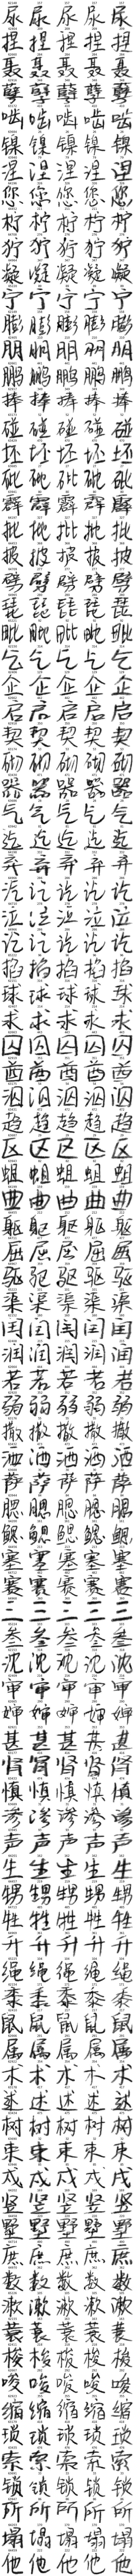

In [14]:
def show_predict(pred, how_much):
    fig, axs = plt.subplots(how_much, 5, figsize=(5 * 2, how_much * 2))
    for i in range(how_much):
        img = test[i]['img']
        axs[i][0].title.set_text(pred[i][1])
        axs[i][0].imshow(img.reshape((img_size,img_size)), cmap="gray")
        axs[i][0].axis('off')
        key = dict_new_labels[pred[i][1]]
        for j, value in enumerate(dictionary[key]):
            if j >= 4:
                break
            axs[i][j + 1].title.set_text(key)
            axs[i][j + 1].imshow(value.reshape((img_size,img_size)), cmap="gray")
            axs[i][j + 1].axis('off')
        
#dictionary = create_dict(train)
#show_predict(predicted, 100)